<a href="https://colab.research.google.com/github/Tndeal/Fashion-recommendation-system/blob/main/DeepFashionData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from bs4 import *
import requests
import os
from os import listdir
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as img
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image
from keras.applications.vgg16 import decode_predictions
import numpy as np
import os
!pip install google-search-results
from serpapi import GoogleSearch
vgg16 = keras.applications.vgg16

#sets up tensorflow configuration
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=config))

def download_images(images, userfilepath):
  count = 0
  i = 0
  #iterates through found images to download
  if len(images) != 0:
      for image in enumerate(images):
        i += 1
        try:
            r = requests.get(image['src']).content
            try:
                r = str(r, 'utf-8')
            except UnicodeDecodeError:
                with open(f"{userfilepath}/images{i+1}.jpg", "wb+") as f:
                    f.write(r)
                    print(r)
                count += 1
        except:
            pass

def main_images(url, userfilepath):
    #accesses url given by user
    r = requests.get(url)
    #uses beautiful soup library to iterate through html and find images
    soup = BeautifulSoup(r.text, 'html.parser')
    images = soup.findAll('img')
    print(images)
    download_images(images, userfilepath)
    #filters out smaller images (profile photos)
    for image in os.listdir(userfilepath):
        im = Image.open(os.path.join(userfilepath,image))

        width, height = im.size
        print(width, height)
        if width < 100:
            os.remove(os.path.join(userfilepath,image))

#extracts all possible category names from the list of images
def sortdata(data_file):
  category_list = []
  text_file = open(data_file)
  lines = text_file.readlines()
  for i in range (2, len(lines)):
    split = lines[i].split('/')
    title = split[1]
    if title not in category_list:
      category_list.append(title)
  print(len(category_list))
  return category_list

#sets up training and validation datasets
def setup_datasets(dataset_location):
  imagedatagenerator = keras.preprocessing.image.ImageDataGenerator(
      preprocessing_function = vgg16.preprocess_input,
      horizontal_flip = True,
      validation_split = 0.1)

  train_dataset = imagedatagenerator.flow_from_directory(
      directory = dataset_location,
      target_size = (224, 224),
      classes = category_list,
      batch_size = 64,
      subset = 'training')

  val_dataset = imagedatagenerator.flow_from_directory(
      directory = dataset_location,
      target_size = (224, 224),
      classes = category_list,
      batch_size = 64,
      subset = 'validation')

  return train_dataset, val_dataset

#changes vgg16 model to specific parameters
def alter_model(vgg_model):
  x = keras.layers.Flatten()(vgg_model.output)
  x = keras.layers.Dense(100, activation='sigmoid')(x)
  x = keras.layers.Dense(100, activation='sigmoid')(x)
  x = keras.layers.Dense(100, activation='sigmoid')(x)
  predictions = keras.layers.Dense(5621, activation='softmax')(x)
  full_model = keras.models.Model(inputs=vgg_model.input, outputs=predictions)
  full_model.summary()
  return full_model

#prepares the images for the model and runs the model to predict categories
def run_model(path):
  img = tf.keras.preprocessing.image.load_img(path, target_size=(224,224))
  subject = tf.keras.preprocessing.image.img_to_array(img)
  subject = preprocess_input(subject)
  subject = np.expand_dims(subject, axis = 0)
  features = full_model.predict(subject)
  features = np.argmax(features, axis=1)
  features = int(features)
  name = category_list[features]
  return name, img

#returns list of categories of the images
def return_model_run():
  allimages = []
  for i in os.listdir(userfilepath):
    name, image = run_model(os.path.join(folder_path, i))
    allimages.append(name)
    print(display(image), name)
    print(allimages)
  return allimages


#sorts list of categories by most common
def find_frequencies(category_list):
  frequency = {}

  for name in category_list:
    if name in frequency:
      frequency[name] += 1
    else:
      frequency[name] = 1

  frequency_list = []
  for key, value in frequency.items():
    frequency_list.append([key, value])

  return frequency_list

def merge(left, right):
    print('merging', left, right)
    i = 0
    j = 0
    sortedlist = []
    while i < len(left) and j < len(right):
        if left[i][1] > right[j][1]:
            sortedlist.append(left[i])
            i += 1
        else:
            sortedlist.append(right[j])
            j += 1

    while j < len(right):
        sortedlist.append(right[j])
        j += 1
    while i< len(left):
        sortedlist.append(left[i])
        i += 1
    return sortedlist

def mergesort(givenlist):
    if len(givenlist) != 1:
        midpoint = len(givenlist) // 2
        left = givenlist[:midpoint]
        right = givenlist[midpoint:]
        print('left', left, 'right', right)
        left = mergesort(left)
        right = mergesort(right)
        return merge(left, right)
    else:
      return givenlist


#uses API and parameters to search for the most popular category from the images
#subject to maximum price given
def search_ebay(item):
  params = {
    "engine": "ebay",
    "_nkw": f"{item}",
    "location": "United Kingdom",
    "ebay_domain": "ebay.com",
    "hl": "en",
    "gl": "uk",
    "api_key": "5d4e269b5b82f516868d604bbbfbc27353b4890f26b7403ffb465210d90f8d3e",
    "tbs": f",ppr_min:0,ppr_max:{maxprice}"
    "num": "3"
  }
  search = GoogleSearch(params)
  results = search.get_dict()
  return results

#TAKING INPUTS
url = input("Please enter url")
while 'pinterest.co.uk' not in url:
  print('Please enter a link to a pinterest board')
  url = input("Please enter url")
print('link accepted')
user_file = input('please enter file name to be stored under')
maxprice = input('please enter max price of clothing')
while maxprice.isdigit() == False:
  print('Please enter a numerical value')
  maxprice = input('please enter max price of clothing')
print('price accepted')
userfilepath = os.path.join('/content', user_file)

#DOWNLOADING IMAGES
#check if file already exists/create file
while os.path.exists(userfilepath) == True:
  check = input('file already exists, use this file? Y/N')
  if check == 'N':
    user_file = input('please enter file name to be stored under')
os.makedirs(userfilepath)
main_images(url, userfilepath)

#sort data
category_list = sortdata('/content/drive/MyDrive/Adatamanipulation/list_category_img.txt')
!unzip /content/drive/MyDrive/Adatamanipulation/img.zip

#create training and valdidation datasets
train_dataset, val_dataset = setup_datasets('/content/img')
X_train, y_train = next(train_dataset)

#setup initial vgg16 model
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))
vgg_model.trainable = False
vgg_model.summary()

#alter vgg16 model
full_model = alter_model(vgg_model)
full_model.compile(
    optimizer=tf.keras.optimizers.Adamax(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['acc'])

#train model
history = full_model.fit(train_dataset, validation_data = val_dataset, workers=0, epochs=5)

#test model and return image-class pairs
allimages = return_model_run()

#sort classes into most popular
allimages = find_frequencies(allimages)
sorted = mergesort(allimages)
sorted_list = []
for i in range (0, len(sorted)):
  sorted_list.append(sorted[i][0])
print(sorted_list)

#return ebay search results
for i in range (0, 3):
  item = sorted_list[i].split('_')
  item = ' '.join(item)
  results = search_ebay(item)
#results = pd.DataFrame.from_dict(results)
  for i in range (0, 3):
    print(results['organic_results'][i]['link'])

print(results)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for google-search-results: filename=google_search_results-2.4.2-py3-none-any.whl size=32019 sha256=970d66857c75aec9a31c13474d08982c3a473c720f50cfcbb4bd7706a165f6c6
  Stored in directory: /root/.cache/pip/wheels/68/8e/73/744b7d9d7ac618849d93081a20e1c0deccd2aef90901c9f5a9
Successfully built google-search-results


In [ ]:
!pip install google-search-results
from serpapi import GoogleSearch
import pandas as pd
sorted_list = ['red_dress', 'black_jacket', 'pink_shoes']
def search_ebay(item):
  params = {
    "engine": "ebay",
    "_nkw": f"{item}",
    "location": "United Kingdom",
    "ebay_domain": "ebay.com",
    "hl": "en",
    "gl": "uk",
    "api_key": "5d4e269b5b82f516868d604bbbfbc27353b4890f26b7403ffb465210d90f8d3e",
    "tbs": f"ppr_min:0,ppr_max:50",
    "num" : "3"
  }
  search = GoogleSearch(params)
  results = search.get_dict()
  return results

for i in range (0, 3):
  item = sorted_list[i].split('_')
  item = ' '.join(item)
  results = search_ebay(item)

#results = pd.DataFrame.from_dict(results)
  for i in range (0, 3):
    print(results['organic_results'][i]['link'])

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
https://www.ebay.com/itm/402340982838?var=672334082955&hash=item5dad643036:g:SG8AAOSwCY5fH3GV&amdata=enc%3AAQAHAAAAwKVLCSDPQLtjJWiKR2vVn3eIPNvSJQYoPt5dUE%2FuS8aNq2REVN8zBjgHjlGktasUg4426oG4jImmGibHaT2%2Ba2B6a0feW6%2FPUVZ%2FsWaL7CE%2BoV5OBqyYSGmdhAY9qCaNW1gIxlh1i70Rwis%2FlStsw%2FMuhJQzVMGMPhrj%2Fbr7bM0rZbWO4efTTdJzXNu1hlD%2BYyD3sFt0lOJw3%2Fob9CpZgcgASYYzsbV53pxfc%2FCYB%2FypM8KRlPhZwSkS9j7JqzCQvg%3D%3D%7Ctkp%3ABlBMUMy3sozjYQ
https://www.ebay.com/itm/401499439262?var=672927666012&hash=item5d7b3b409e:g:y6EAAOSwcQ9gB4kZ&amdata=enc%3AAQAHAAAAwGBhPan%2Bb13kS%2BcT%2Bh8wn9g6Vd7P5tjtHp6KfAASlmVB6KLrX0B2xYf6m3ZrSt7bXv3GjkpM8tHiWZUJW86xzrrK5m7xpXfUQi5JUo%2FpgBbTNV0%2BPH6dmszwTM5byjHXWP1C4McQf40RI3iOn2vut6LhBETKvuHg6rsqII%2FAdZLBpJfW7abnzRSANzfU8mM4RBWfFqT%2F9DpqYo5eS5d5B1OyYPkcO9HMMjvsC55nUbw6lipIEN2PlmR0oDSwNaFLkQ%3D%3D%7Ctkp%3ABlBMUM63sozjYQ
https://www.ebay.com/itm/264789158064?var=565276988067&ha

In [ ]:
import os
os.makedirs('/content/usertest2')

In [ ]:
from bs4 import *
import requests
import os
from os import listdir
from PIL import Image

def download_images(images, userfilepath):
  count = 0
  #iterates through found images to download
  if len(images) != 0:
      for i,image in enumerate(images):
        try:
            r = requests.get(image['src']).content
            try:
                r = str(r, 'utf-8')
            except UnicodeDecodeError:
                with open(f"{userfilepath}/images{i+1}.jpg", "wb+") as f:
                    f.write(r)
                    print(r)
                count += 1
        except:
            pass

def main_images(url, userfilepath):
    #accesses url given by user
    r = requests.get(url)
    #uses beautiful soup library to iterate through html and find images
    soup = BeautifulSoup(r.text, 'html.parser')
    images = soup.findAll('img')
    print(images)
    download_images(images, userfilepath)
    #filters out smaller images (profile photos)
    for image in os.listdir(userfilepath):
        im = Image.open(os.path.join(userfilepath,image))

        width, height = im.size
        print(width, height)
        if width < 100:
            os.remove(os.path.join(userfilepath,image))
            print('image removed')

#TAKING INPUTS
import os
url = input("Please enter url")
while 'pinterest.co.uk' not in url:
  print('Please enter a link to a pinterest board')
  url = input("Please enter url")
print('link accepted')
maxprice = input('please enter max price of clothing')
while maxprice.isdigit() == False:
  print('Please enter a numerical value')
  maxprice = input('please enter max price of clothing')
print('price accepted')
user_file = input('please enter file name to be stored under')
userfilepath = os.path.join('/content', user_file)


#DOWNLOADING IMAGES
#check if file already exists/create file
exists = os.path.exists(userfilepath)
valid = False
while exists == True:
  check = input('file already exists, use this folder? Y/N')
  if check == 'N':
    userfilepath = input('please enter folder name to be stored under')
    exists = os.path.exists(userfilepath)
  else:
    valid = True
    print(f'{userfilepath} will be used as images folder')
    exists = False
if valid == False:
  os.makedirs(userfilepath)
  print(f'{userfilepath} created')

main_images(url, userfilepath)

Please enter urlhttps://www.pinterest.co.uk/user_drihtaaa/fashion/
link accepted
please enter max price of clothing50
price accepted
please enter file name to be stored underuser-test
file already exists, use this folder? Y/NY
/content/user-test will be used as images folder
[<img alt="" class="hCL kVc L4E MIw N7A XiG" fetchpriority="auto" loading="auto" src="https://i.pinimg.com/70x/55/6f/9a/556f9afacbd32e1528c3b4d068324b59.jpg" style="object-fit:cover"/>, <img alt="" class="hCL kVc L4E MIw N7A XiG" fetchpriority="auto" loading="auto" src="https://i.pinimg.com/70x/d5/16/ea/d516ea9ee763692a34cb53c7001492d8.jpg" style="object-fit:cover"/>, <img alt="Street Style Outfits, Mode Outfits, Fashion Outfits, Womens Fashion, Street Style Trends, Looks Style, Looks Cool, Colourful Outfits, Colorful Fashion" class="hCL kVc L4E MIw" fetchpriority="auto" loading="auto" src="https://i.pinimg.com/236x/30/6e/2d/306e2dd2160392daa7183a4ddb75f218.jpg"/>, <img alt="6 High-Street Fashion Influencers We Rel

In [ ]:
ls

In [ ]:

allimages = ['shirt', 'shorts', 'shorts', 'shirt', 'skirt', 'shorts']
def find_frequencies(category_list):
  frequency = {}
  for name in category_list:
    if name in frequency:
      frequency[name] += 1
    else:
      frequency[name] = 1

  frequency_list = []
  for key, value in frequency.items():
    frequency_list.append([key, value])

  return frequency_list

def merge(left, right):
    print('merging', left, right)
    i = 0
    j = 0
    sortedlist = []
    while i < len(left) and j < len(right):
        if left[i][1] > right[j][1]:
            sortedlist.append(left[i])
            i += 1
        else:
            sortedlist.append(right[j])
            j += 1

    while j < len(right):
        sortedlist.append(right[j])
        j += 1
    while i< len(left):
        sortedlist.append(left[i])
        i += 1
    return sortedlist

def mergesort(givenlist):
    if len(givenlist) != 1:
        midpoint = len(givenlist) // 2
        left = givenlist[:midpoint]
        right = givenlist[midpoint:]
        print('left', left, 'right', right)
        left = mergesort(left)
        right = mergesort(right)
        return merge(left, right)
    else:
      return givenlist

allimages = find_frequencies(allimages)
sorted = mergesort(allimages)
sorted_list = []
for i in range (0, len(sorted)):
  sorted_list.append(sorted[i][0])
print(sorted_list)

left [['shirt', 2]] right [['shorts', 3], ['skirt', 1]]
left [['shorts', 3]] right [['skirt', 1]]
merging [['shorts', 3]] [['skirt', 1]]
merging [['shirt', 2]] [['shorts', 3], ['skirt', 1]]
['shorts', 'shirt', 'skirt']


In [ ]:
def merge(left, right):
    print('merging', left, right)
    i = 0
    j = 0
    sortedlist = []
    while i < len(left) and j < len(right):
        if left[i][1] > right[j][1]:
            sortedlist.append(left[i])
            i += 1
        else:
            sortedlist.append(right[j])
            j += 1

    while j < len(right):
        sortedlist.append(right[j])
        j += 1
    while i< len(left):
        sortedlist.append(left[i])
        i += 1
    return sortedlist

def mergesort(givenlist):
    if len(givenlist) != 1:
        midpoint = len(givenlist) // 2
        left = givenlist[:midpoint]
        right = givenlist[midpoint:]
        print('left', left, 'right', right)
        left = mergesort(left)
        right = mergesort(right)
        return merge(left, right)
    else:
        return givenlist

givenlist = frequency_list
sorted = mergesort(givenlist)
print(sorted)
sorted_list = []
for i in range (0, len(sorted)):
  sorted_list.append(sorted[i][0])
print(sorted_list)

left [['shirt', 2]] right [['shorts', 3], ['skirt', 1]]
left [['shorts', 3]] right [['skirt', 1]]
merging [['shorts', 3]] [['skirt', 1]]
merging [['shirt', 2]] [['shorts', 3], ['skirt', 1]]
[['shorts', 3], ['shirt', 2], ['skirt', 1]]
['shorts', 'shirt', 'skirt']


In [ ]:
def merge(left, right):
    print('merging', left, right)
    i = 0
    j = 0
    sortedlist = []
    while i < len(left) and j < len(right):
        if left[i] > right[j]:
            sortedlist.append(left[i])
            i += 1
        else:
            sortedlist.append(right[j])
            j += 1

    while j < len(right):
        sortedlist.append(right[j])
        j += 1
    while i< len(left):
        sortedlist.append(left[i])
        i += 1
    return sortedlist

def mergesort(givenlist):
    if len(givenlist) != 1:
        midpoint = len(givenlist) // 2
        left = givenlist[:midpoint]
        right = givenlist[midpoint:]
        print('left', left, 'right', right)
        left = mergesort(left)
        right = mergesort(right)
        return merge(left, right)
    else:
        return givenlist

givenlist = [1, 7, 3, 8, 5]
print(mergesort(givenlist))

left [1, 7] right [3, 8, 5]
left [1] right [7]
merging [1] [7]
left [3] right [8, 5]
left [8] right [5]
merging [8] [5]
merging [3] [8, 5]
merging [7, 1] [8, 5, 3]
[8, 7, 5, 3, 1]


In [ ]:
url = input("Please enter url")
while 'pinterest.co.uk' not in url:
  print('Please enter a link to a pinterest board')
  url = input("Please enter url")
print('link accepted')
user_file = input('please enter file name to be stored under')
maxprice = input('please enter max price of clothing')
while maxprice.isdigit() == False:
  print('Please enter a numerical value')
  maxprice = input('please enter max price of clothing')
print('price accepted')

Please enter urlhttps://www.office.com/?auth=2
Please enter a link to a pinterest board
Please enter urlhttps://www.pinterest.co.uk/user_drihtaaa/fashion/
link accepted
please enter file name to be stored underuser-test
please enter max price of clothinga
Please enter a numerical value
please enter max price of clothing50
price accepted


In [ ]:
#@title Default title text
from bs4 import *
import requests
import os
from os import listdir
from PIL import Image

def download_images(images, userfilepath):
  count = 0
  i = 0
  if len(images) != 0:
      for image in enumerate(images):
        i += 1
          try:
              r = requests.get(image['src']).content
              try:
                  r = str(r, 'utf-8')
              except UnicodeDecodeError:
                  with open(f"{userfilepath}/images{i+1}.jpg", "wb+") as f:
                      f.write(r)
                      print(r)
                  count += 1
          except:
              pass



def main(url, userfilepath):
    r = requests.get(url)
    soup = BeautifulSoup(r.text, 'html.parser')
    images = soup.findAll('img')
    print(images)
    download_images(images, userfilepath)
    for image in os.listdir(userfilepath):
        im = Image.open(os.path.join(userfilepath,image))

        width, height = im.size
        print(width, height)
        if width < 100:
            os.remove(os.path.join(userfilepath,image))

url = input("Please enter url")
user_file = input('please enter file name to be stored under')
maxprice = input('please enter max price of clothing')
userfilepath = os.path.join('/content', user_file)
print(filepath)
if os.path.exists(userfilepath) == False:
  os.makedirs(userfilepath)
main(url, userfilepath)


Please enter urlhttps://www.pinterest.co.uk/user_drihtaaa/fashion/
please enter file name to be stored underthiara-test
please enter max price of clothing50
/content/thiara-test
[<img alt="" class="hCL kVc L4E MIw N7A XiG" fetchpriority="auto" loading="auto" src="https://i.pinimg.com/70x/55/6f/9a/556f9afacbd32e1528c3b4d068324b59.jpg" style="object-fit:cover"/>, <img alt="" class="hCL kVc L4E MIw N7A XiG" fetchpriority="auto" loading="auto" src="https://i.pinimg.com/70x/d5/16/ea/d516ea9ee763692a34cb53c7001492d8.jpg" style="object-fit:cover"/>, <img alt="Street Style Outfits, Mode Outfits, Fashion Outfits, Womens Fashion, Street Style Trends, Looks Style, Looks Cool, Colourful Outfits, Colorful Fashion" class="hCL kVc L4E MIw" fetchpriority="auto" loading="auto" src="https://i.pinimg.com/236x/30/6e/2d/306e2dd2160392daa7183a4ddb75f218.jpg"/>, <img alt="6 High-Street Fashion Influencers We Religiously Follow | Who What Wear UK Striped Sweater Outfit, Stripe Outfits, Jumper And Jeans Outfit

In [ ]:
category_list = []
text_file = open('/content/drive/MyDrive/Adatamanipulation/list_category_img.txt')
lines = text_file.readlines()
for i in range (2, len(lines)):
  split = lines[i].split('/')
  title = split[1]
  if title not in category_list:
    category_list.append(title)
print(category_list)
print('\n'.join(category_list))

['Sheer_Pleated-Front_Blouse', 'Sheer_Woven_Blouse', 'Shirred_Floral-Embroidered_Blouse', 'Shirred_Lace-Paneled_Blouse', 'Side-Slit_Collared_Blouse', 'Side-Slit_Striped_Blouse', 'Single-Button_Blazer', 'Sleek_Draped_Blouse', 'Sleek_Woven_Pocket_Blouse', 'Sleeveless_Classic_Woven_Blouse', 'Sleeveless_Vented_Blouse', 'Slub_Knit_Buttoned-Back_Blouse', 'Boxy_Split-Neck_Blouse', 'Southwestern_Print_Blouse', 'Speckled_Slub_Knit_Blouse', 'Split_V-Neck_Chiffon_Blouse', 'Split-Back_Pleated_Blouse', 'Split-Neck_Chiffon_Blouse', 'Split-Neck_Dolman_Blouse', 'Stripe_Print_Surplice_Blouse', 'Striped_Chiffon_Blouse', 'Striped_Floral_Blouse', 'Striped_Mandarin_Collar_Blouse', 'Striped_Open-Knit_Blouse', 'Striped_Tribal_Print_Blouse', 'Striped_Twist-Front_Blouse', 'Sweet_Crochet_Blouse', 'Tab-Sleeved_Chiffon_Blouse', 'Tailored_Woven_Blazer', 'Tartan_Plaid_Blouse', 'Tartan_Plaid_Button-Down', 'Tartan_Plaid_Chiffon_Blouse', 'Tasseled_Neckline_Floral_Blouse', 'Tasseled_Neckline_Stripe_Blouse', 'Textured_B

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
print(len(category_list))

5621


In [ ]:
!unzip /content/drive/MyDrive/Adatamanipulation/img.zip

Streaming output truncated to the last 5000 lines.
  inflating: img/Woven_Dolphin_Shorts/img_00000027.jpg  
  inflating: img/Woven_Dolphin_Shorts/img_00000028.jpg  
  inflating: img/Woven_Dolphin_Shorts/img_00000029.jpg  
  inflating: img/Woven_Dolphin_Shorts/img_00000030.jpg  
  inflating: img/Woven_Dolphin_Shorts/img_00000031.jpg  
  inflating: img/Woven_Dolphin_Shorts/img_00000032.jpg  
  inflating: img/Woven_Dolphin_Shorts/img_00000033.jpg  
  inflating: img/Woven_Dolphin_Shorts/img_00000034.jpg  
  inflating: img/Woven_Dolphin_Shorts/img_00000035.jpg  
  inflating: img/Woven_Dolphin_Shorts/img_00000036.jpg  
  inflating: img/Woven_Dolphin_Shorts/img_00000037.jpg  
   creating: img/Woven_Drawstring_Joggers/
  inflating: img/Woven_Drawstring_Joggers/img_00000001.jpg  
  inflating: img/Woven_Drawstring_Joggers/img_00000002.jpg  
  inflating: img/Woven_Drawstring_Joggers/img_00000003.jpg  
  inflating: img/Woven_Drawstring_Joggers/img_00000004.jpg  
  inflating: img/Woven_Drawstring_J

/content/img


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import matplotlib.pyplot as plt
import matplotlib.image as img
import numpy as np
import tensorflow as tf
from tensorflow import keras

config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=config))

In [ ]:
dataset_location = '/content/img'


from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
vgg16 = keras.applications.vgg16

imagedatagenerator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function = vgg16.preprocess_input,
    horizontal_flip = True,
    validation_split = 0.1)

train_dataset = imagedatagenerator.flow_from_directory(
    directory = dataset_location,
    target_size = (224, 224),
    classes = category_list,
    batch_size = 64,
    subset = 'training'
)

val_dataset = imagedatagenerator.flow_from_directory(
    directory = dataset_location,
    target_size = (224, 224),
    classes = category_list,
    batch_size = 64,
    subset = 'validation'
)
X_train, y_train = next(train_dataset)
print(len(train_dataset), len(val_dataset))

NameError: ignored

In [ ]:
from bs4 import *
import requests
import os
from os import listdir
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as img
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image
from keras.applications.vgg16 import decode_predictions
import numpy as np
import os
!pip install google-search-results
from serpapi import GoogleSearch
vgg16 = keras.applications.vgg16

config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=config))

vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))
vgg_model.trainable = False
vgg_model.summary()

def sortdata(data_file):
  category_list = []
  text_file = open(data_file)
  lines = text_file.readlines()
  for i in range (2, len(lines)):
    split = lines[i].split('/')
    title = split[1]
    if title not in category_list:
      category_list.append(title)
  print(len(category_list))
  return category_list

def setup_datasets(dataset_location):
  imagedatagenerator = keras.preprocessing.image.ImageDataGenerator(
      preprocessing_function = vgg16.preprocess_input,
      horizontal_flip = True,
      validation_split = 0.1)

  train_dataset = imagedatagenerator.flow_from_directory(
      directory = dataset_location,
      target_size = (224, 224),
      classes = category_list,
      batch_size = 64,
      subset = 'training')

  val_dataset = imagedatagenerator.flow_from_directory(
      directory = dataset_location,
      target_size = (224, 224),
      classes = category_list,
      batch_size = 64,
      subset = 'validation')

  return train_dataset, val_dataset


def alter_model(vgg_model):

  #full_model.add(tf.keras.Input(shape = vgg_model.input)
  vgg_model.add(tf.keras.layers.Flatten())
  vgg_model.add(tf.keras.layers.Dense(100, activation='relu'))
  vgg_model.add(tf.keras.layers.Dense(100, activation='relu'))
  vgg_model.add(tf.keras.layers.Dense(100, activation='relu'))
  vgg_model.add(keras.layers.Dense(5621, activation='softmax'))

  vgg_model.summary()
  return vgg_model


#preparing dataset
category_list = sortdata('/content/drive/MyDrive/Adatamanipulation/list_category_img.txt')
!unzip /content/drive/MyDrive/Adatamanipulation/img.zip

#create training and valdidation datasets
train_dataset, val_dataset = setup_datasets('/content/img')
X_train, y_train = next(train_dataset)

#setup initial vgg16 model
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))
vgg_model.trainable = False
vgg_model.summary()

#alter vgg16 model
full_model = alter_model(vgg_model)
full_model.compile(
    optimizer=tf.keras.optimizers.Adamax(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['acc'])

Streaming output truncated to the last 5000 lines.
  inflating: img/Woven_Drawstring_Skirt/img_00000013.jpg  
  inflating: img/Woven_Drawstring_Skirt/img_00000014.jpg  
  inflating: img/Woven_Drawstring_Skirt/img_00000015.jpg  
  inflating: img/Woven_Drawstring_Skirt/img_00000016.jpg  
  inflating: img/Woven_Drawstring_Skirt/img_00000017.jpg  
  inflating: img/Woven_Drawstring_Skirt/img_00000018.jpg  
  inflating: img/Woven_Drawstring_Skirt/img_00000019.jpg  
  inflating: img/Woven_Drawstring_Skirt/img_00000020.jpg  
  inflating: img/Woven_Drawstring_Skirt/img_00000021.jpg  
  inflating: img/Woven_Drawstring_Skirt/img_00000022.jpg  
  inflating: img/Woven_Drawstring_Skirt/img_00000023.jpg  
  inflating: img/Woven_Drawstring_Skirt/img_00000024.jpg  
  inflating: img/Woven_Drawstring_Skirt/img_00000025.jpg  
  inflating: img/Woven_Drawstring_Skirt/img_00000026.jpg  
  inflating: img/Woven_Drawstring_Skirt/img_00000027.jpg  
  inflating: img/Woven_Drawstring_Skirt/img_00000028.jpg  
  inf

AttributeError: ignored

In [ ]:
from tensorflow.keras import layers, models
x = keras.layers.Flatten()(vgg_model.output)
x = keras.layers.Dense(100, activation='sigmoid')(x)
x = keras.layers.Dense(100, activation='sigmoid')(x)
x = keras.layers.Dense(100, activation='sigmoid')(x)
predictions = keras.layers.Dense(5621, activation='softmax')(x)
full_model = keras.models.Model(inputs=vgg_model.input, outputs=predictions)
full_model.summary()

full_model.compile(
    optimizer=tf.keras.optimizers.Adamax(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['acc'],
)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
history = full_model.fit(train_dataset, validation_data = val_dataset, workers=0, epochs=5)

Epoch 1/5
4108/4108 [==============================] - 1328s 320ms/step - loss: 7.9917 - acc: 0.0028 - val_loss: 7.5112 - val_acc: 0.0068
Epoch 2/5
4108/4108 [==============================] - 1222s 297ms/step - loss: 7.2735 - acc: 0.0087 - val_loss: 7.1779 - val_acc: 0.0123
Epoch 3/5
4108/4108 [==============================] - 1218s 296ms/step - loss: 6.9401 - acc: 0.0136 - val_loss: 7.0637 - val_acc: 0.0147
Epoch 4/5
4108/4108 [==============================] - 1216s 296ms/step - loss: 6.7423 - acc: 0.0175 - val_loss: 7.0506 - val_acc: 0.0168
Epoch 5/5
4108/4108 [==============================] - 1249s 304ms/step - loss: 6.5909 - acc: 0.0212 - val_loss: 6.9603 - val_acc: 0.0188


In [ ]:

!mkdir saved_model
full_model.save('saved_model/my_model.h5')

In [ ]:
!mkdir saved_model
full_model.save('saved_model/my_model.h5')

1/1 [==============================] - 0s 24ms/step


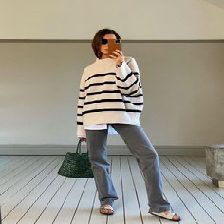

None Tribal-Inspired_Fringed_Cardigan
1/1 [==============================] - 0s 21ms/step


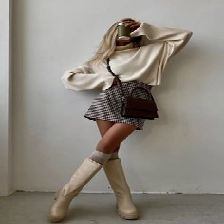

None Polka_Dot_Shorts
1/1 [==============================] - 0s 24ms/step


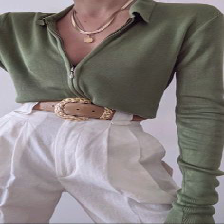

None Striped_Shawl_Collar_Cardigan
1/1 [==============================] - 0s 23ms/step


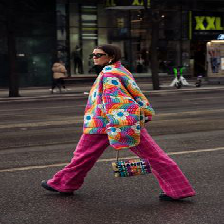

None Fringed_Tribal_Pattern_Cardigan
1/1 [==============================] - 0s 35ms/step


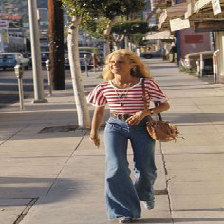

None Destroyed_Cropped_Jeans
1/1 [==============================] - 0s 26ms/step


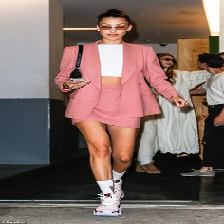

None Plaid_Flannel_Mini_Skirt
1/1 [==============================] - 0s 32ms/step


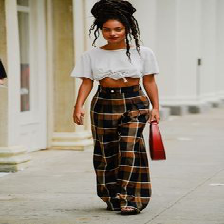

None Leopard_Print_Joggers
['Tribal-Inspired_Fringed_Cardigan', 'Polka_Dot_Shorts', 'Striped_Shawl_Collar_Cardigan', 'Fringed_Tribal_Pattern_Cardigan', 'Destroyed_Cropped_Jeans', 'Plaid_Flannel_Mini_Skirt', 'Leopard_Print_Joggers']


In [ ]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np
import os
allimages = []

def run_model(path):
  img = tf.keras.preprocessing.image.load_img(path, target_size=(224,224))
  subject = tf.keras.preprocessing.image.img_to_array(img)
  subject = preprocess_input(subject)
  subject = np.expand_dims(subject, axis = 0)
  features = full_model.predict(subject)
  features = np.argmax(features, axis=1)
  features = int(features)
  name = category_list[features]
  return name, img

folder_path = userfilepath
for i in os.listdir(folder_path):
  name, image = run_model(os.path.join(folder_path, i))
  allimages.append(name)
  print(display(image), name)


#folder_path = '/content/drive/MyDrive/Adatamanipulation/test_images'
#for i in os.listdir(folder_path):
 #   f = os.path.join(folder_path, i)
##   subject = image.img_to_array(img)
  #  subject = np.expand_dims(subject, axis = 0)
   # subject = preprocess_input(subject)
    #features = full_model.predict(subject)
#    features = np.argmax(features, axis = 1)
 #   features = int(features)
  #  name = category_list[features]
   # allimages.append(name)
   # print(display(img), name)


print(allimages)

In [ ]:
sorted_list = sorted(allimages, key = allimages.count, reverse=True)
sorted_list = set(sorted_list)
sorted_list = list(sorted_list)

print(sorted_list[0])


Fringed_Tribal_Pattern_Cardigan


In [ ]:
!pip install google-search-results
from serpapi import GoogleSearch

item = sorted_list[0].split('_')
item = ' '.join(item)
print(item)

params = {
  "engine": "ebay",
  "_nkw": f"{item}",
  "location": "United Kingdom",
  "ebay_domain": "ebay.com",
  "hl": "en",
  "gl": "uk",
  "api_key": "5d4e269b5b82f516868d604bbbfbc27353b4890f26b7403ffb465210d90f8d3e",
  "tbs": f"mr:1,price:1,ppr_min:0,ppr_max:{maxprice}"
}


search = GoogleSearch(params)
results = search.get_dict()
print(results)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Fringed Tribal Pattern Cardigan
{'search_metadata': {'id': '64174f82e0ded495c7dee923', 'status': 'Success', 'json_endpoint': 'https://serpapi.com/searches/cd066bd52caf12b5/64174f82e0ded495c7dee923.json', 'created_at': '2023-03-19 18:08:02 UTC', 'processed_at': '2023-03-19 18:08:02 UTC', 'ebay_url': 'https://www.ebay.com/sch/i.html?_nkw=Fringed+Tribal+Pattern+Cardigan', 'raw_html_file': 'https://serpapi.com/searches/cd066bd52caf12b5/64174f82e0ded495c7dee923.html', 'total_time_taken': 2.04}, 'search_parameters': {'engine': 'ebay', '_nkw': 'Fringed Tribal Pattern Cardigan'}, 'search_information': {'organic_results_state': 'Results for exact spelling', 'total_results': 11, 'query_displayed': 'Fringed Tribal Pattern Cardigan'}, 'categories': [{'name': 'Clothing, Shoes & Accessories', 'id': '11450'}, {'name': "Women's Sweaters", 'id': '63866'}, {'name': "Women's Coats, Jackets & Vests", 'id': '